# MIMO System Identification for Ground Motion Events

In [1]:
import ssid
from ssid import modal, spec
import sdof
import numpy as np
from numpy import linspace, sqrt, pi
from ssid.utilities.config import Config
from ssid.utilities.printing import *
from ssid.numerics import decimate

## Unknown multi-input, multi-output system
parameter | value
----------|-------
$m_{1}$  | mass 
$\omega_i$  | natural periods, $i \in [1,\text{nmodes}]$
$\zeta_i$  | damping ratios, $i \in [1,\text{nmodes}]$

![2dof](./figures/2dof.png)

PEER NGA West

In [2]:
# Import some PEER Data

import csv
peer_motion_metadata = {}

with open("./PEERNGARecords_Unscaled/_SearchResultsMetadata.csv", "r") as readfile:
    csv_reader = csv.DictReader(readfile, delimiter=",")
    for rows in csv_reader:
        key = rows["Result ID"]
        peer_motion_metadata[key] = rows

arrays = {i: {key: value for key,value in peer_motion_metadata.items()
              if value[" Station Name"] == f' "El Centro Array #{i}"'}
              for i in np.arange(1,20)}

print("station number,   number of records,    event names")
for key,value in arrays.items():
    if len(value) > 5:
        print(key, len(value), [event[' Earthquake Name'] for event in value.values()])

arrays_imp06 = {i: {key: value for key,value in peer_motion_metadata.items()
                    if value[" Station Name"] == f' "El Centro Array #{i}"'
                    and value[' Earthquake Name'] == ' "Imperial Valley-06"'}
                    for i in np.arange(1,20)}

h1s_imp06 = {array:record[' Horizontal-1 Acc. Filename'] 
             for array,records in arrays_imp06.items() 
             for record_id,record in records.items()
             if len(records)>0}


station number,   number of records,    event names
7 6 [' "Imperial Valley-06"', ' "Imperial Valley-07"', ' "Anza-02"', ' "Gulf of California"', ' "CA/Baja Border Area"', ' "El Mayor-Cucapah_ Mexico"']
9 9 [' "Imperial Valley-01"', ' "Imperial Valley-02"', ' "Borrego"', ' "Imperial Valley-03"', ' "Imperial Valley-04"', ' "Imperial Valley-05"', ' "El Alamo"', ' "Borrego Mtn"', ' "Gulf of California"']
10 7 [' "Imperial Valley-06"', ' "Imperial Valley-07"', ' "Hector Mine"', ' "Anza-02"', ' "Gulf of California"', ' "CA/Baja Border Area"', ' "El Mayor-Cucapah_ Mexico"']
11 6 [' "Imperial Valley-06"', ' "Imperial Valley-07"', ' "Anza-02"', ' "Gulf of California"', ' "CA/Baja Border Area"', ' "El Mayor-Cucapah_ Mexico"']


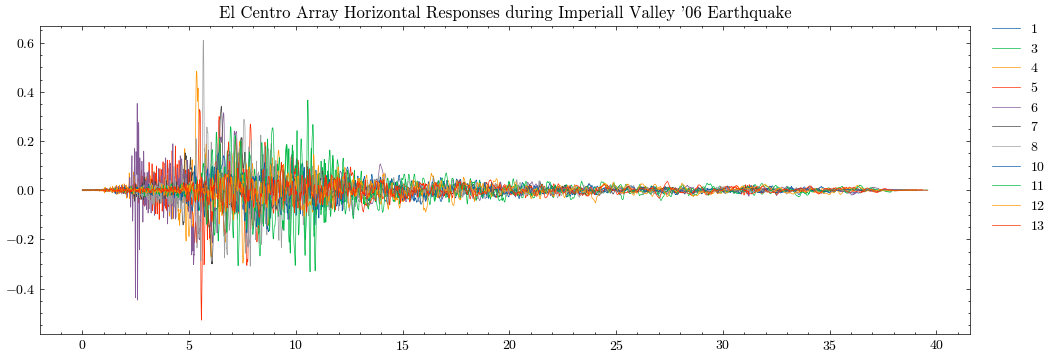

In [3]:
import quakeio

plt.figure(figsize=(12,4))
for array,filename in h1s_imp06.items():
    filename = filename[1:]
    inputs  = quakeio.read(f"PEERNGARecords_Unscaled/{filename}").data
    dt = 0.005
    # ta = np.arange(0, inputs.size*dt, dt)
    t = linspace(0, (inputs.size-1)*dt, len(inputs))
    plt.plot(t, inputs, label=array, linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 1.05))
    plt.title("El Centro Array Horizontal Responses during Imperiall Valley '06 Earthquake")

## Configure

### Inputs:

In [4]:
inputs  = np.loadtxt("uploads/elcentro.txt")
dt = 0.02

# ta = np.arange(0, inputs.size*dt, dt)
t = linspace(0, (inputs.size-1)*dt, len(inputs))

### Outputs

In [5]:
outputs = None

In [6]:
# Example SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio

Generate output if one was not given:

In [7]:
if outputs is None:
    omega_n = sqrt(k/mass)  # natural frequency (rad/s)
    Tn = 2*pi/omega_n  # natural periods (s)
    c = 2*zeta*mass*omega_n    # damping coefficient
    print(f"natural period: {Tn:<3.5}s")
    print(f"damping ratio:  {zeta}")
    displ, veloc, outputs = sdof.integrate(mass,c,k,inputs,dt)

natural period: 1.1471s
damping ratio:  0.01


#### Method

In [8]:
conf = Config()
conf.r = 2
conf.decimation = 1

## Analysis with System Identification

#### Transfer Function ("Non-parametric") Methods

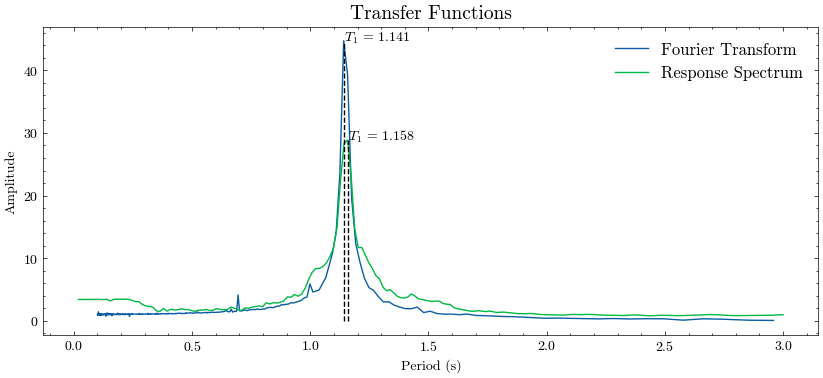

In [9]:
# Set parameters
conf.damping = zeta
conf.period_band = (0.1,3) # Period band (s)
conf.pseudo = True # use pseudo accelerations (Sa)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = spec.fourier_transfer(inputs, outputs, dt, **conf)
transfer_models["Response Spectrum"] = spec.response_transfer(inputs, outputs, dt, **conf)
plot_transfer(transfer_models, title="Transfer Functions")

# Determing the fundamental frequency
fundamental_fourier = modal.spectrum_modes(*transfer_models["Fourier Transform"])
fundamental_response = modal.spectrum_modes(*transfer_models["Response Spectrum"])
plt.gcf().axes[0].vlines([fundamental_fourier[0], fundamental_response[0]],ymin=[0,0],ymax=[fundamental_fourier[1],fundamental_response[1]],linestyles='--',colors='k')
plt.gcf().axes[0].text(fundamental_fourier[0],fundamental_fourier[1],r"$T_{1}$ = "+str(np.round(fundamental_fourier[0][0],3)))
plt.gcf().axes[0].text(fundamental_response[0],fundamental_response[1],r"$T_{1}$ = "+str(np.round(fundamental_response[0][0],3)));

#### State Space ("Parametric") Methods

In [10]:
# Generate a state space realization of the system
conf.decimation = 6
realization = ssid.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 366/367 [00:00<00:00, 77374.76it/s]

Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC          T % error    ζ % error
      1.147      0.009474   1.0        1.0        1.0          -0.02227     -5.264   
Mean Period(s): 1.1468919384772662
Standard Dev(s): 0.0


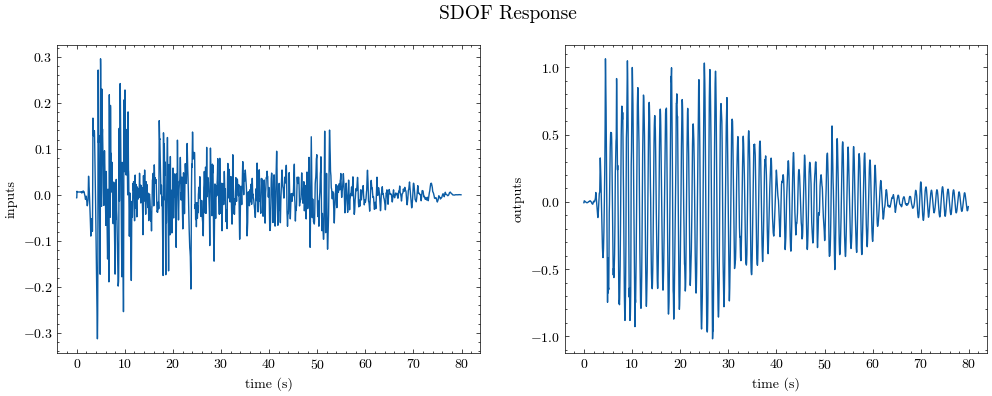

In [11]:
plot_io(inputs=inputs, outputs=outputs, t=t, title="SDOF Response")

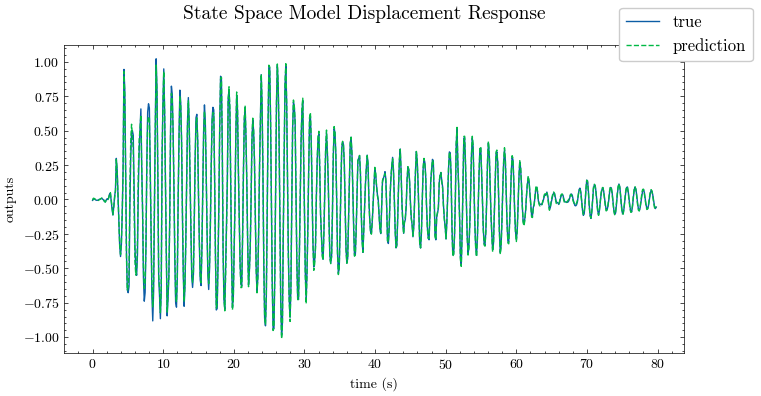

In [12]:
# Reproduce the response with the state space model
from control import ss, forced_response
out_ssid = forced_response(ss(*realization,dt*conf.decimation), U=decimate(inputs,conf.decimation), squeeze=False, return_x=False).outputs
plot_pred(ytrue=decimate(outputs,conf.decimation), models=out_ssid, t=decimate(t,conf.decimation), title="State Space Model Displacement Response")